In [1]:
import megyr
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from scipy import stats
import warnings
import sys
sys.path.append('../../')
from TESStools import *

In [2]:
#we're going to match the T_eff/LogL of HD 269953
fyps = pd.read_csv('../../fyps.csv')
cool_sgs = pd.read_csv('../../cool_supergiants_TESS.csv')
this_star = fyps[fyps['CommonName'] == 'HD 269953']
this_T, this_L = this_star[['teff','lum']].values[0]
this_T, this_L

(3.692, 5.437)

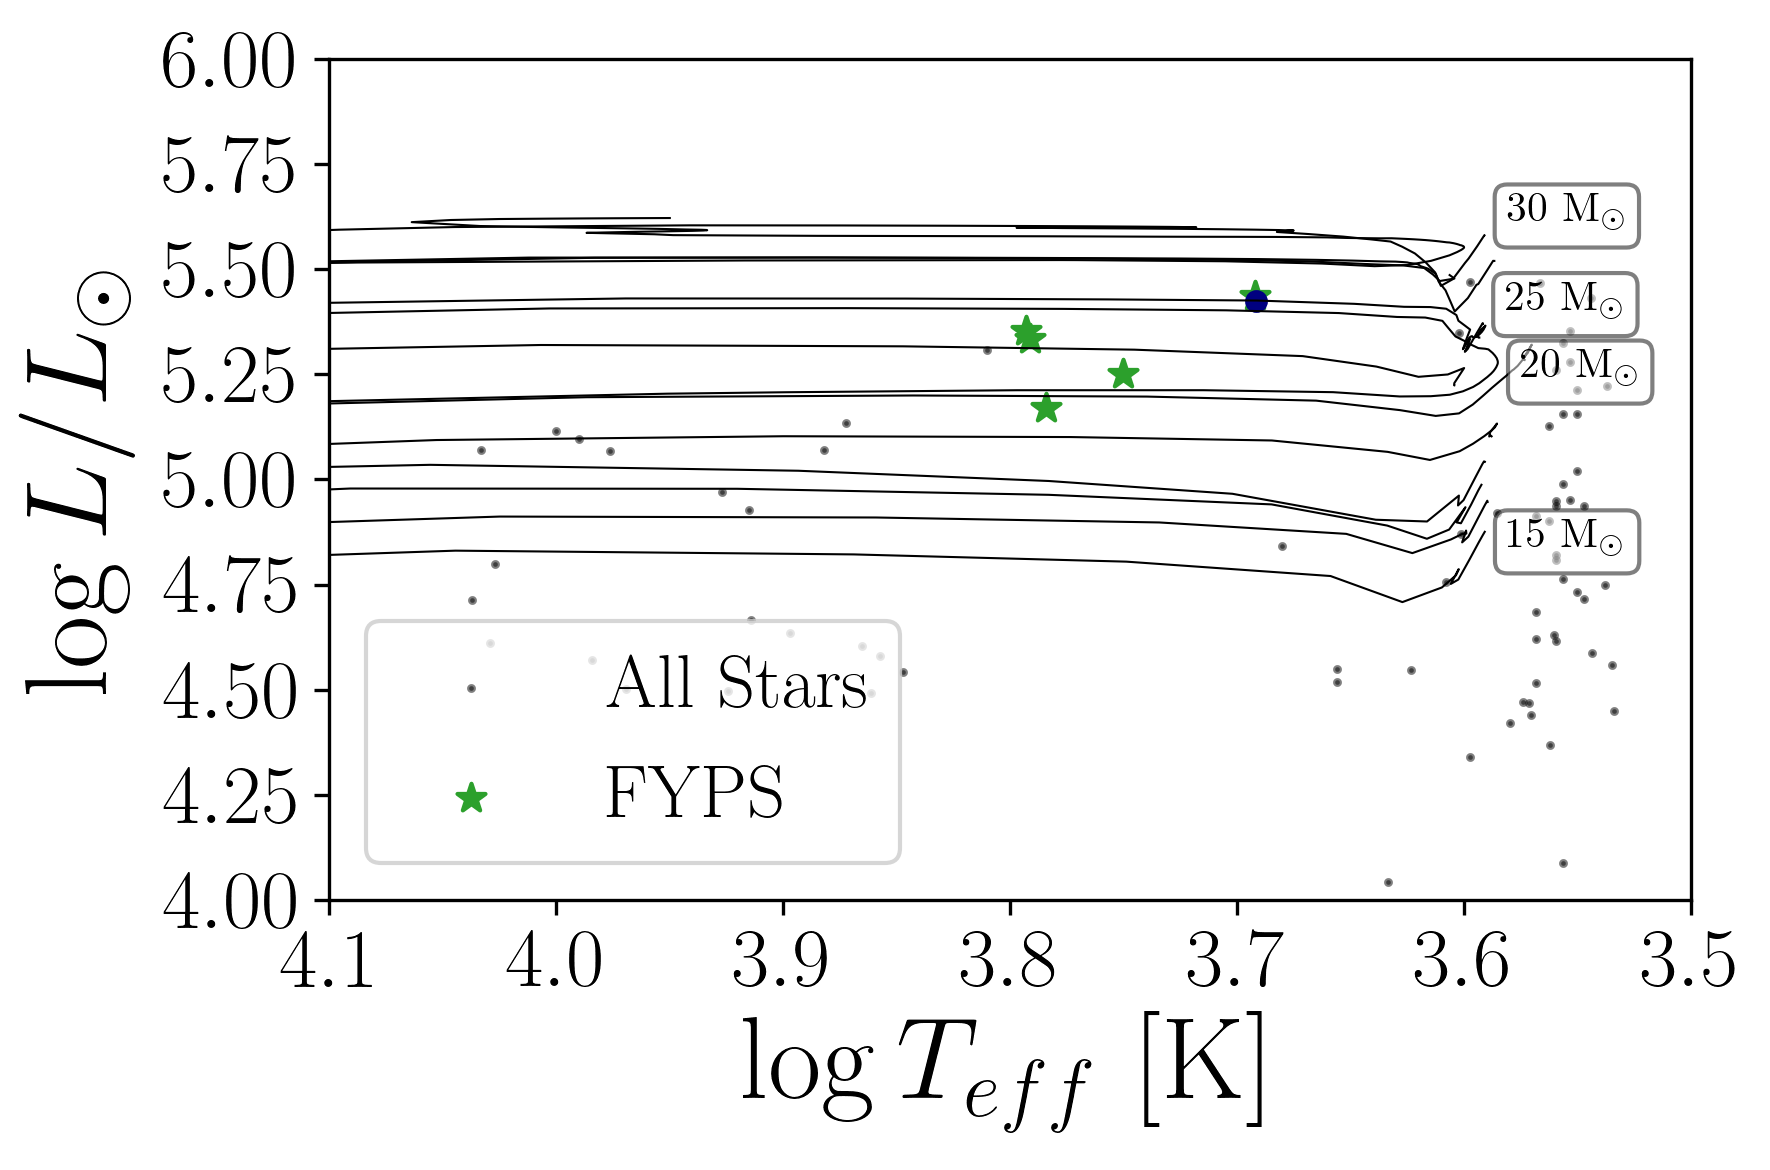

In [15]:
fig = plt.figure(dpi=300)

#Plot MESA tracks
dfs = []
for m in [15,16,17,18,19,20,21,23,25,26,27,28,29,30]: #No 22, 24 M_sun tracks
    try:
        model = pd.read_csv(f'out_post/mesa_initial_mass_{m}__/mesa_profile_attributes.csv')
        dfs.append(model)
        #model = model.iloc[:np.argmin(model['Teff'])]
        plt.plot(np.log10(model['Teff']),np.log10(model['photosphere_L']),c='k',lw=0.5)
    except:
        pass
    if m % 5 == 0:
        if m in (15,20):
            offset = -0.05
        elif m == 25:
            offset = 0.02
        plt.text(np.log10(model['Teff']).min()-0.01,np.log10(model['photosphere_L'][np.argmin(model['Teff'])])+offset,
                     str(m)+r' M$_\odot$',bbox=dict(facecolor='white',boxstyle='round',alpha=0.5))
all_mods = pd.concat(dfs).reset_index(drop=True)
best_fit = all_mods.iloc[np.argmin(np.sqrt((np.log10(all_mods['Teff'].values) - this_T)**2.0 + (np.log10(all_mods['photosphere_L'].values) - this_L)**2.0))]

plt.scatter(cool_sgs['teff'],cool_sgs['lum'],s=5,marker='.',c='k',alpha=0.5,label='All Stars')
plt.scatter(fyps['teff'],fyps['lum'],marker='*',s=50,c='C2',label='FYPS')
plt.scatter(np.log10(best_fit['Teff']),np.log10(best_fit['photosphere_L']),c='navy',s=20)


plt.legend(fontsize=18,loc='lower left')

plt.xlabel('$\log{T_{eff}}$ [K]')
plt.ylabel('$\log{L/L_\odot}$')

ax= plt.gca()
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.ylim(4,6)
plt.xlim(4.1,3.5)
plt.tight_layout()
plt.savefig('../../../plots/tracks_hr.pdf')

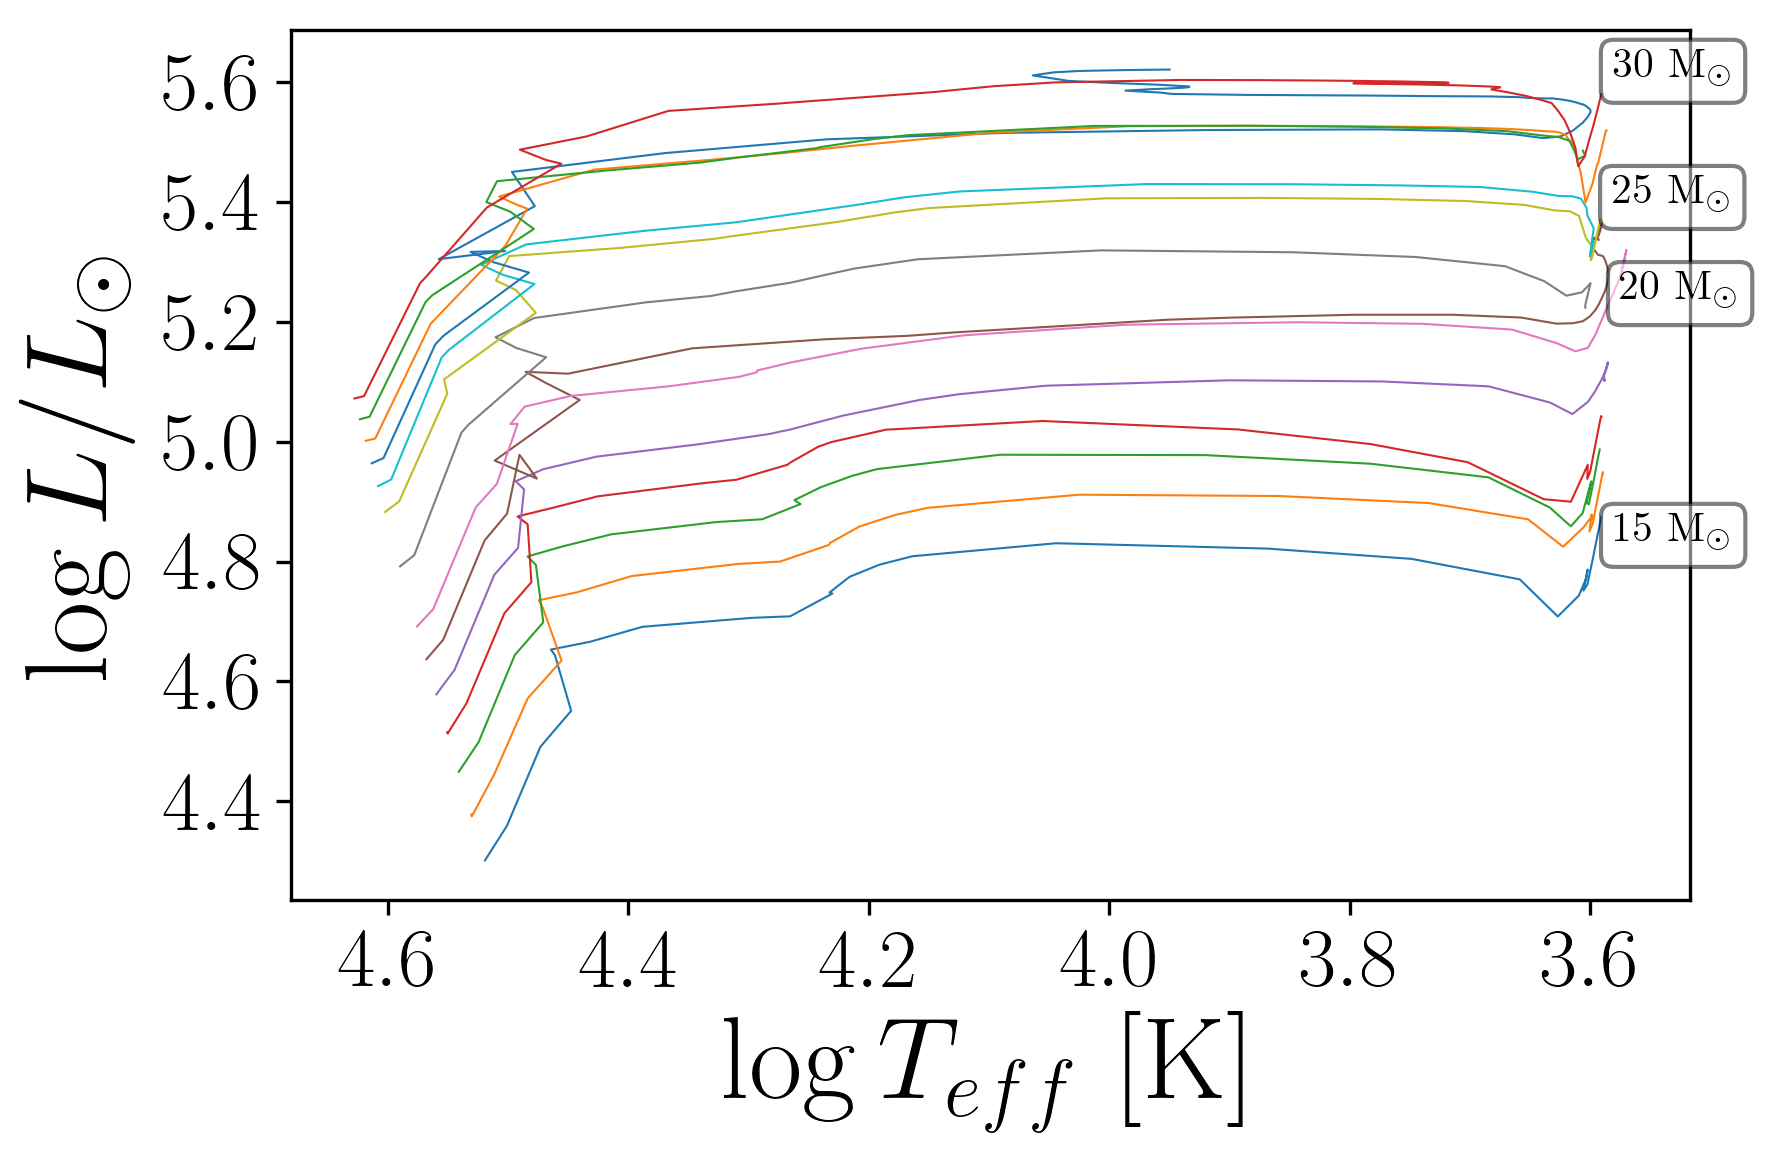

In [14]:
fig = plt.figure(dpi=300)

#Plot MESA tracks
dfs = []
for m in [15,16,17,18,19,20,21,23,25,26,27,28,29,30]: #No 22, 24 M_sun tracks
    try:
        model = pd.read_csv(f'out_post/mesa_initial_mass_{m}__/mesa_profile_attributes.csv')
        dfs.append(model)
        #model = model.iloc[:np.argmin(model['Teff'])]
        plt.plot(np.log10(model['Teff']),np.log10(model['photosphere_L']),lw=0.5)
    except:
        pass
    if m % 5 == 0:
        if m in (15,20):
            offset = -0.05
        elif m == 25:
            offset = 0.02
        plt.text(np.log10(model['Teff']).min()-0.01,np.log10(model['photosphere_L'][np.argmin(model['Teff'])])+offset,
                     str(m)+r' M$_\odot$',bbox=dict(facecolor='white',boxstyle='round',alpha=0.5))

plt.xlabel('$\log{T_{eff}}$ [K]')
plt.ylabel('$\log{L/L_\odot}$')

ax= plt.gca()
ax.invert_xaxis()
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
#plt.ylim(4,6)
#plt.xlim(4.1,3.5)
plt.tight_layout()

In [8]:
best_fit_m = int(best_fit['initial_mass'])
best_fit_mod = best_fit['model_number']
best_model = pd.read_csv(f'out_post/mesa_initial_mass_{best_fit_m}__/mesa_profile_attributes.csv')
best_model[best_model['model_number']==best_fit_mod]
#Best is profile 19 = 18+1 (zero indexed)

,model_number,num_zones,initial_mass,initial_z,star_age,time_step,Teff,photosphere_L,photosphere_r,center_eta,...,burn_min1,burn_min2,time_seconds,version_number,compiler,build,MESA_SDK_version,math_backend,date,profile
18,1600,1689,26.0,0.006,7.212750e+06,174.757579,4912.340035,266301.062151,713.458051,-3.916114,...,50.0,1000.0,2.276211e+14,"""12778""","""gfortran""","""9.2.0""","""x86_64-macos-20.3.1""","""CRMATH""","""20200429""",19


In [9]:
best_row = best_model[best_model['model_number']==best_fit_mod]
best_row['star_mass_o16'],best_row['star_mass_c12'],best_row['star_mass_ne20']

(18    3.614008
 Name: star_mass_o16, dtype: float64, 18    1.739083
 Name: star_mass_c12, dtype: float64, 18    0.046656
 Name: star_mass_ne20, dtype: float64)

In [10]:
from megyr.profile import read_profile_file
best_fit_dir = f'out_post/mesa_initial_mass_{best_fit_m}__/'
best_fit_profs = glob(best_fit_dir+'LOGS/profile*.data')
X_m = []
Y_m = []
mass = []
logage = []
for i in range(len(best_fit_profs)):
    j = i+1
    prof = read_profile_file(f'out_post/mesa_initial_mass_{best_fit_m}__/LOGS/profile{j}.data')
    mass.append(prof.attributes['star_mass'].values[0])
    logage.append(np.log10(prof.attributes['star_age'].values[0]))
    X_flag = True
    Y_flag = False
    Z_flag = False
    for i,row in prof.data.iterrows():
        if X_flag:
            if row['y_mass_fraction_He'] >= row['x_mass_fraction_H']:
                X_flag = False
                Y_flag = True
                X_m.append(row['mass'])
        elif Y_flag:
            if row['z_mass_fraction_metals'] >= row['y_mass_fraction_He']:
                Y_flag = False
                Z_flag = True
                Y_m.append(row['mass'])
        elif Z_flag:
            break
        else:
            print('No flags set?', X_flag, Y_flag, Z_flag)
    #if the whole thing is hydrogen dominated, X_flag never got turned off
    if X_flag:
        X_m.append(0)
        Y_m.append(0)
    #if only has a helium core, no strong metals build up:
    elif Y_flag:
        Y_m.append(0)

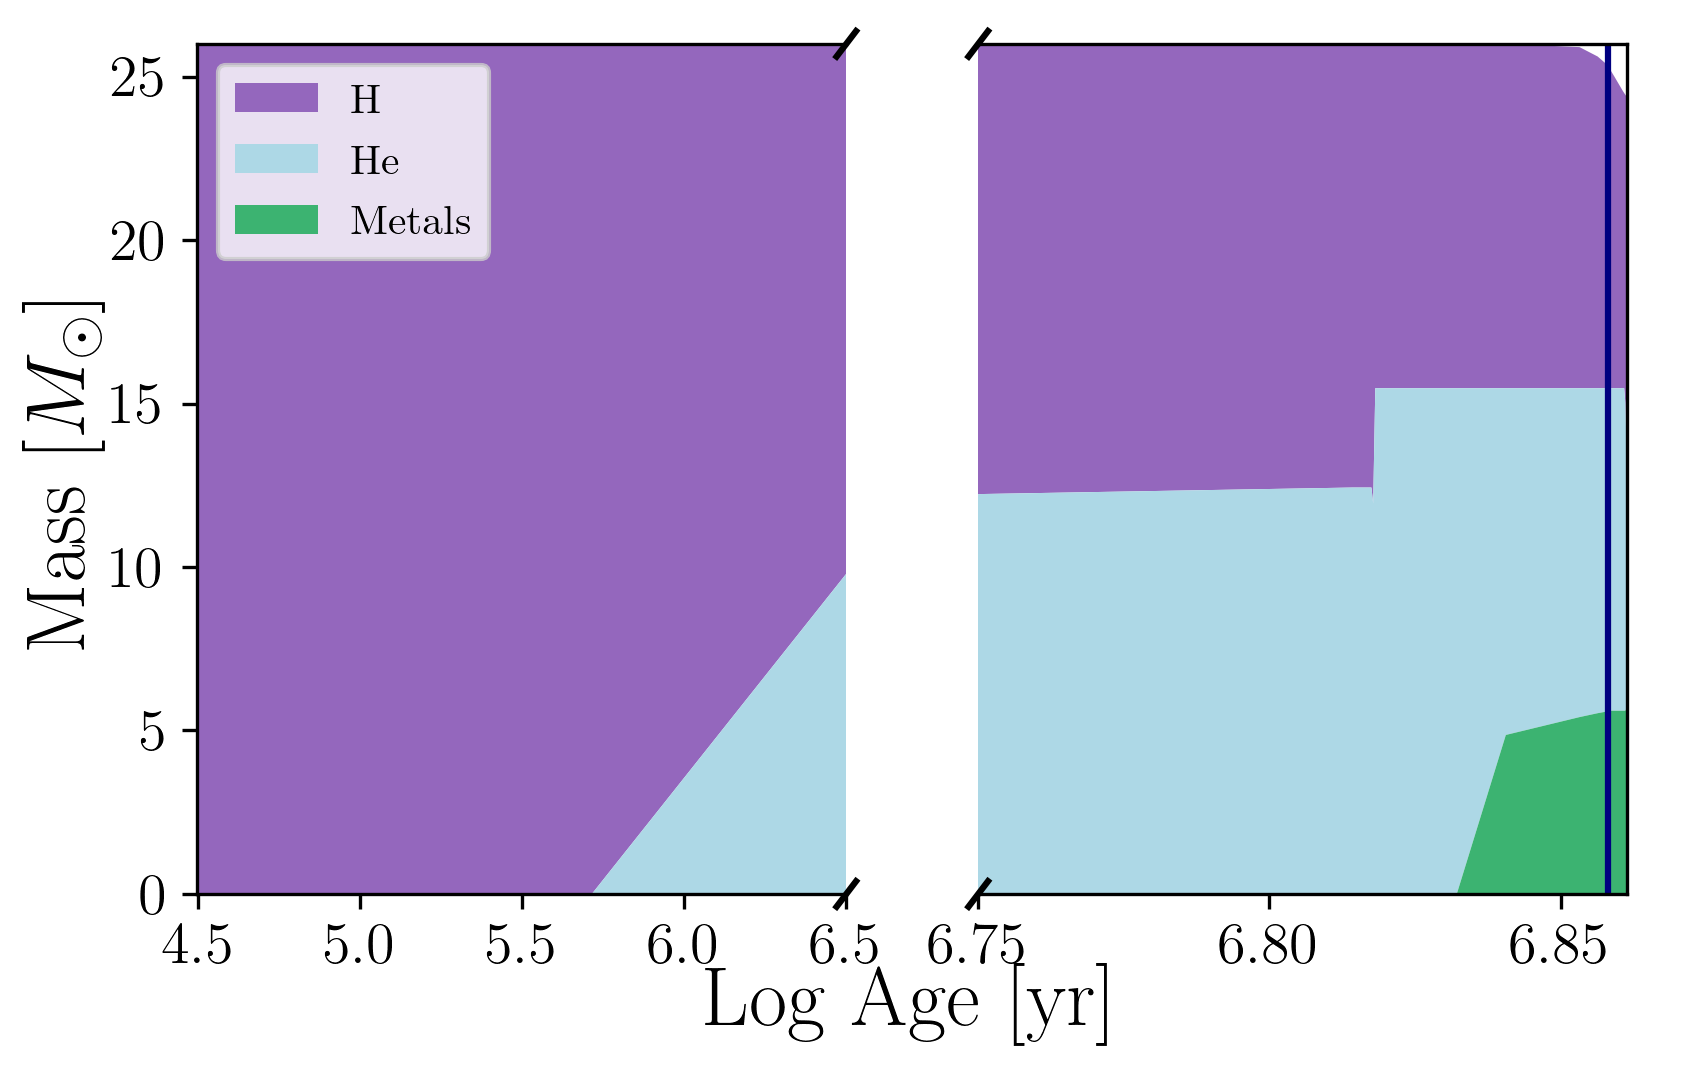

In [11]:
f, (ax, ax2) = plt.subplots(1, 2, sharey=True,dpi=300)

# plot the same data on both axes
ax.fill_between(logage,X_m,mass,fc='C4',label='H')
ax.fill_between(logage,X_m,Y_m,fc='lightblue',label='He')
ax.fill_between(logage,0,Y_m,fc='mediumseagreen',label='Metals')

# plot the same data on both axes
ax2.fill_between(logage,X_m,mass,fc='C4')
ax2.fill_between(logage,X_m,Y_m,fc='lightblue')
ax2.fill_between(logage,0,Y_m,fc='mediumseagreen')
ax2.axvline(x=np.log10(best_fit['star_age']),c='navy')

# zoom-in / limit the view to different portions of the data
ax.set_xlim(np.min(logage), 6.5)  # outliers only
ax2.set_xlim(6.75, np.max(logage))  # most of the data

ax.set_ylim(0,best_fit_m)

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(axis='y',length=0)
#ax.tick_params(labeltop=False)  # don't put tick labels at the top
#ax2.xaxis.tick_bottom()


d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
#ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # top-right diagonal
ax.plot((1 - d, 1 + d), (- d, + d), **kwargs)  # bottom-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
#ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
#
ax2.plot((-d, +d), (-d, +d), **kwargs)        # bottom-left diagonal
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)  # top-left diagonal
ax.legend(loc='upper left')
ax2.set_xticks([6.75,6.8,6.85])

#Axis labels
labax = f.add_subplot(111)
labax.spines['top'].set_color('none')
labax.spines['bottom'].set_color('none')
labax.spines['left'].set_color('none')
labax.spines['right'].set_color('none')
labax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off', length=0)
labax.set_xlabel(r'Log Age [yr]',fontsize=20,family='serif')
labax.set_ylabel(r'Mass [$M_\odot$]',fontsize=20,family='serif')
labax.set_zorder(-1)

for a in (ax,ax2):
    for tick in a.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in a.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)

f.subplots_adjust(hspace=0.25)
f.tight_layout()
plt.savefig('../../../plots/kippenhahn.pdf')

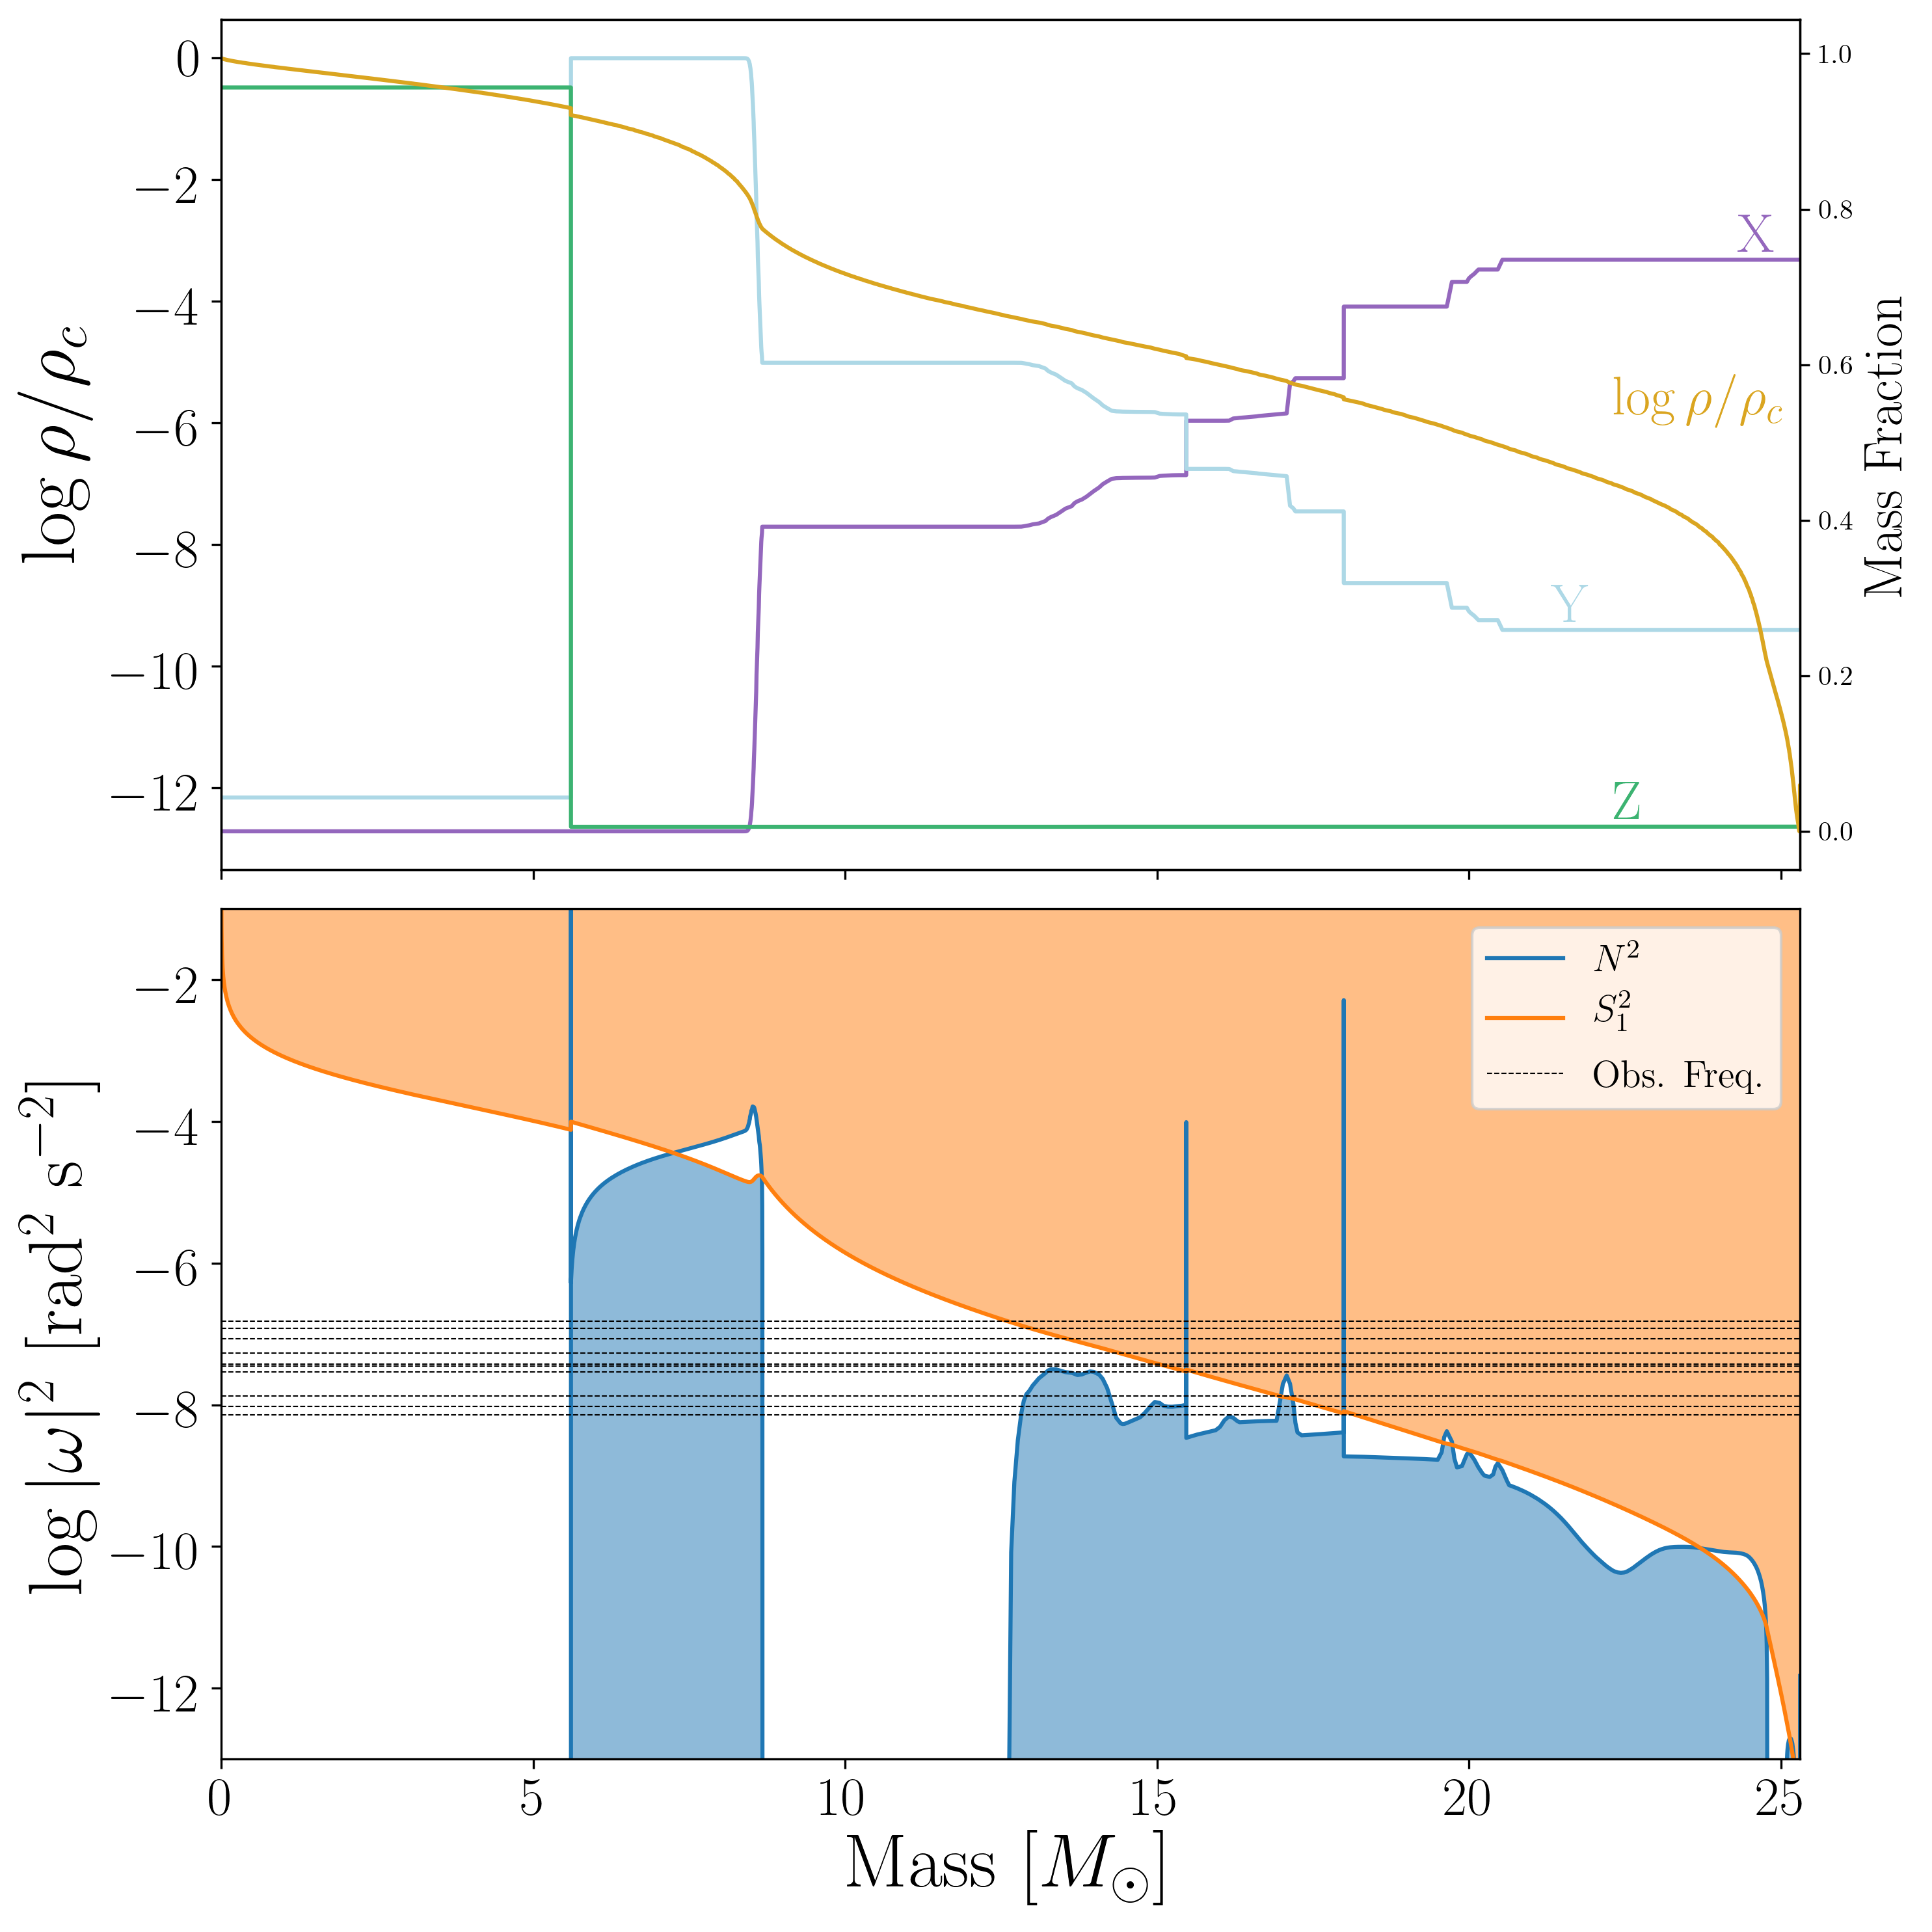

In [12]:
import astropy.units as u

these_fs = np.array([1.59348824, 2.67043002, 1.33522847, 1.17418715, 4.00571582, 3.18691508, 4.78027694, 5.34124582, 2.34860073, 2.57294069])
these_fs = 2*np.pi*these_fs * (u.rad/u.day).to(u.rad/u.second)

prof = read_profile_file(f'out_post/mesa_initial_mass_{best_fit_m}__/LOGS/profile19.data')
profile = prof.data
log_N2 = np.log10(np.clip(profile['brunt_N2'].values, 1e-15, None))
log_S2 = np.log10(np.clip(profile['lamb_S2'].values, 1e-15, None))

fig, axes = plt.subplots(2, dpi=300,sharex=True,figsize=(10,10))

axes[0].plot(profile['mass'],profile['logRho']-profile['logRho'].max(),c='goldenrod')
axes[0].set_ylabel(r'$\log \rho/\rho_c$')
axes[0].text(profile['mass'].max()-3,-6,r'$\log\rho/\rho_c$',fontsize=20,c='goldenrod')


twax = axes[0].twinx()
twax.plot(profile['mass'],profile['x_mass_fraction_H'],c='C4',label='X')
twax.plot(profile['mass'],profile['y_mass_fraction_He'],c='lightblue',label='Y')
twax.plot(profile['mass'],profile['z_mass_fraction_metals'],c='mediumseagreen',label='Z')
twax.text(profile['mass'].max()-1,profile['x_mass_fraction_H'].values[0]+0.01,'X',fontsize=20,c='C4')
twax.text(profile['mass'].max()-4,profile['y_mass_fraction_He'].values[0]+0.01,'Y',fontsize=20,c='lightblue')
twax.text(profile['mass'].max()-3,profile['z_mass_fraction_metals'].values[0]+0.01,'Z',fontsize=20,c='mediumseagreen')



twax.set_ylabel('Mass Fraction')
twax.yaxis.label.set_size(20)
for tick in twax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
twax.set_zorder(ax2.get_zorder()-1) # put ax in front of ax2 
axes[0].patch.set_visible(False) # hide the 'canvas' 

axes[1].plot(profile['mass'],log_N2,label='$N^2$')
axes[1].plot(profile['mass'],log_S2,label='$S_1^2$')
max_g = []
min_p = []
for n2,s2 in zip(log_N2,log_S2):
    if n2 <= s2:
        max_g.append(n2)
        min_p.append(s2)
    else:
        max_g.append(s2)
        min_p.append(n2)
axes[1].fill_between(profile['mass'], max_g, axes[0].get_ylim()[0], facecolor='C0', alpha=0.5, interpolate=True)
axes[1].fill_between(profile['mass'], min_p, axes[0].get_ylim()[1], facecolor='C1', alpha=0.5, interpolate=True)
#axes[1].fill_between(x, y1, y2, where=y2 <= y1, facecolor='red', interpolate=True)
axes[1].axhline(y=np.log10(these_fs[0]**2.0),c='k',lw=0.5,ls='--',label='Obs. Freq.')
for f in these_fs[1:]:
    axes[1].axhline(y=np.log10(f**2.0),c='k',ls='--',lw=0.5)
axes[1].set_ylim(-13,-1)
axes[1].set_xlim(0,best_row['star_mass'].values[0])
axes[1].set_xlabel(r'Mass [$M_\odot$]')
axes[1].set_ylabel(r'$\log |\omega|^2$ [rad$^{2}$ s$^{-2}$]')
axes[1].legend(loc='upper right',fontsize=14)
for ax in axes:
    ax.xaxis.label.set_size(28)
    ax.yaxis.label.set_size(28)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)

    
plt.tight_layout()


plt.savefig('../../../plots/propagation_diagram.pdf')